<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Librerías" data-toc-modified-id="Librerías-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Librerías</a></span></li><li><span><a href="#Funciones" data-toc-modified-id="Funciones-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Funciones</a></span></li><li><span><a href="#Base-de-Datos---Airlines" data-toc-modified-id="Base-de-Datos---Airlines-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Base de Datos - Airlines</a></span><ul class="toc-item"><li><span><a href="#Preprocesamiento-y-Creación-de-Features" data-toc-modified-id="Preprocesamiento-y-Creación-de-Features-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Preprocesamiento y Creación de Features</a></span><ul class="toc-item"><li><span><a href="#Features:-Padded-Sequences" data-toc-modified-id="Features:-Padded-Sequences-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Features: Padded Sequences</a></span></li><li><span><a href="#Features:-One-Hot-Encoding" data-toc-modified-id="Features:-One-Hot-Encoding-3.1.2"><span class="toc-item-num">3.1.2&nbsp;&nbsp;</span>Features: One Hot Encoding</a></span></li></ul></li><li><span><a href="#Modelos-de-Clasificación" data-toc-modified-id="Modelos-de-Clasificación-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Modelos de Clasificación</a></span><ul class="toc-item"><li><span><a href="#Regresión-Logística" data-toc-modified-id="Regresión-Logística-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Regresión Logística</a></span></li><li><span><a href="#Naive-Bayes" data-toc-modified-id="Naive-Bayes-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Naive Bayes</a></span></li><li><span><a href="#Support-Vector-Machines" data-toc-modified-id="Support-Vector-Machines-3.2.3"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>Support Vector Machines</a></span></li><li><span><a href="#Neural-Networks" data-toc-modified-id="Neural-Networks-3.2.4"><span class="toc-item-num">3.2.4&nbsp;&nbsp;</span>Neural Networks</a></span><ul class="toc-item"><li><span><a href="#Neural-Networks:-MP" data-toc-modified-id="Neural-Networks:-MP-3.2.4.1"><span class="toc-item-num">3.2.4.1&nbsp;&nbsp;</span>Neural Networks: MP</a></span></li><li><span><a href="#Neural-Networks:-LSTM" data-toc-modified-id="Neural-Networks:-LSTM-3.2.4.2"><span class="toc-item-num">3.2.4.2&nbsp;&nbsp;</span>Neural Networks: LSTM</a></span></li><li><span><a href="#Neural-Networks:-Transformer" data-toc-modified-id="Neural-Networks:-Transformer-3.2.4.3"><span class="toc-item-num">3.2.4.3&nbsp;&nbsp;</span>Neural Networks: Transformer</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#Conclusiones" data-toc-modified-id="Conclusiones-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Conclusiones</a></span></li></ul></div>

# Análisis de Sentimiento - Clasificación de Texto

En este notebook se pretende realizar un __análisis de sentimiento (clasificación de texto)__ para dos conjuntos de datos distintos. 

Este notebook hace parte (y es el comienzo) de la serie de notebooks y scripts del curso de __Tópicos de Estadística Avanzada (DS y ML)__ tomado en la Universiad Nacional de Colombia.

## Librerías 

En esta seccion se importan las librerías y modulos que se van a usar a lo largo del notebook.

In [1]:
# Se importan modelos y funciones param mostrar imagenes
from IPython.display import Image
from IPython.core.display import HTML 

# DS y ML
import pandas as pd
import numpy as np
from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils.multiclass import unique_labels
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer

## Funciones

En esta sección se encuentran las funciones personalizadas que se usarán a lo largo del notebook.

In [2]:
#Function which objective is to plot in a fancy way the confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")

    #print(cm)

    fig, ax = plt.subplots(figsize = (10,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=0, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

## Base de Datos - Airlines

En este primer capítulo se va a realizar el análisis de sentimiento para el conjunto de datos `../Data/Tweets/AirlinesTweets.csv` el cual contiene tweets acerca la opiniones de distintas aereolíneas, para más información ir [aquí](https://www.kaggle.com/crowdflower/twitter-airline-sentiment?select=Tweets.csv).

In [3]:
# Lea el .csv de tweets
pd_tweets = pd.read_csv('../Data/Tweets/AirlinesTweets.csv', sep=',')
pd_tweets.head(n=2)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)


Lo normal es hacer un fuerte __análisis descriptivo y exploratorio__ de los datos que se tienen para cada una de las aereolíneas y los cada uno de los tipos de sentimiento (positivo, negativo y neutro).

Por ahora vamos a ver la nube de palabras para cada tipo de sentimiento para ver si de manera general se tienen algunas diferencias. 

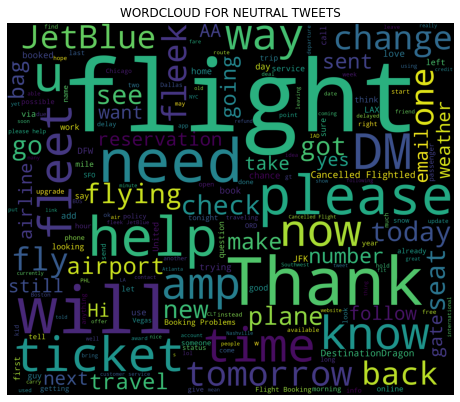

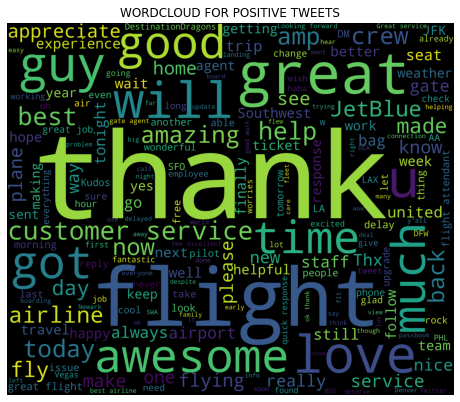

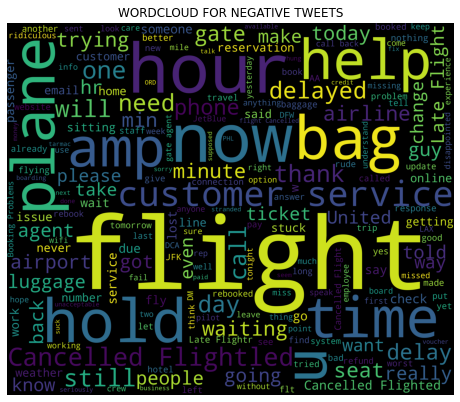

In [4]:
# Grafica la nube de palabras para cada uno de los sentimientos (las clases o etiquetas de los tweets)
sentiments = pd_tweets['airline_sentiment'].unique().tolist()

# Recorre cada sentimiento y hace su nube de palabras 
for s in sentiments:
    # Cocnatena las palabras de los tweets cuya etiqueta es s
    words = ' '.join(pd_tweets.loc[pd_tweets['airline_sentiment'] == s, 'text'])
    cleaned_words = " ".join([word for word in words.split()
                                if 'http' not in word
                                    and not word.startswith('@')
                                    and word != 'RT'
                                ])
    # Genera y grafica la nube de palabras
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500,
                     ).generate(cleaned_words)
    plt.figure(1,figsize=(8, 8))
    plt.imshow(wordcloud)
    plt.title('WORDCLOUD FOR {} TWEETS'.format(s.upper()))
    plt.axis('off')
    plt.show()

### Preprocesamiento y Creación de Features

En esta sección se pretende realizar el preprocesamiento y creación de features para los tweets, que en un principio son texto el cual debemos mapear a variables numéricas.

In [5]:
# Transformacion de labels a categorias numericas
sentiment_labels = pd_tweets['airline_sentiment'].factorize()
sentiment_labels

(array([0, 1, 0, ..., 0, 2, 0]),
 Index(['neutral', 'positive', 'negative'], dtype='object'))

#### Features: Padded Sequences

Se crean features que capturen la secuencia del texto, es decir que mantengan el orden del tweet.

In [6]:
# Realiza un tokenizacion de los tweets
tweets = pd_tweets['text'].values

# Tokenizador: se le pasa un numero maximo de palabras
lim_words = 5000
tokenizer = Tokenizer(num_words=lim_words)
tokenizer.fit_on_texts(tweets)
# Tamaño del vocabulario
vocab_size = len(tokenizer.word_index) + 1
# Realiza el sumergimiento de los textos en secuencias numericas
encoded_docs = tokenizer.texts_to_sequences(tweets)
max_len = 200
padded_sequence_features = pad_sequences(encoded_docs, maxlen=max_len)

In [7]:
# Imprime un ejemplo de un tweets, sus tokens, y como se ve como secuencia
idx = 0
print('EJEMPLO DE TWEET: {}'.format(tweets[idx]))
print('TOKENS: {}'.format(encoded_docs[idx]))
print('SECUENCIA: {}'.format(padded_sequence_features[0]))

EJEMPLO DE TWEET: @VirginAmerica What @dhepburn said.
TOKENS: [81, 62, 226]
SECUENCIA: [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  81
  62 226]


#### Features: One Hot Encoding

Se crean features que capturen las palabras que se encuentren en el texto.

In [8]:
# Realiza un tokenizacion de los tweets
tweets = pd_tweets['text'].values

# Se genera una sparse matrix con el one hot encode por palabra (y doble palabra)
one_hot_features = tokenizer.texts_to_matrix(tweets)

In [9]:
# Imprime un ejemplo de un tweets, sus tokens, y como se ve como secuencia
idx = 0
print('EJEMPLO DE TWEET: {}'.format(tweets[idx]))
print('ONE HOT ENCODED TWEET: {}'.format(one_hot_features[0]))

EJEMPLO DE TWEET: @VirginAmerica What @dhepburn said.
ONE HOT ENCODED TWEET: [0. 0. 0. ... 0. 0. 0.]


### Modelos de Clasificación

En esta sección se van a realizar diversos modelos de clasificación para nuestro problema:

<span style="color:blue">
<br>
1. Regresión Logística. <br>
2. Naive Bayes. <br>
3. Support Vector Machine (SVM). <br>
4. Neural Neetwork (NNs como LSTMs o Transformers). <br>
</span>

Y se pretende comparar las métricas de los modelos resultantes.

Previamente hay qeu resaltar que algunos de estos algoritmos __no entienden las secuencias__, da igual el orden de los features creados, por lo tanto, para modelos que no manejen secuencias como la regresión logística, naive bayes, support vector machines, perceptrón multicapa, etc se usará los features one hot encode por palabra `one_hot_features`. Mientras que para los modelos que entiendan secuencias como LSTMs o Transformers se usarán las secuencias `padded_sequence_features`.

#### Regresión Logística

`### TO DO`

#### Naive Bayes

`### TO DO`

#### Support Vector Machines

`### TO DO`

#### Neural Networks

`### TO DO`

##### Neural Networks: MP

##### Neural Networks: LSTM

##### Neural Networks: Transformer

## Conclusiones

`### TO DO`

# Final del Documento